# Processing the results

In [1]:
import os
import random
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.ion()
sns.set_context('paper', font_scale=2, rc={'lines.linewidth': 2})
sns.set_style(style='whitegrid')

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
import sys
sys.path.insert(0, '../')

## Loading a photo

In [4]:
import cv2

In [5]:
image = cv2.imread('../data/300W/02_Outdoor/outdoor_255.png')

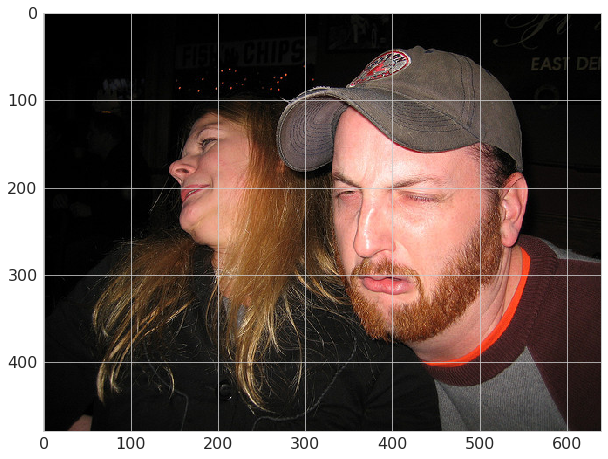

In [6]:
plt.imshow(image[:,:,::-1])

In [41]:
cv2.imwrite('figs/orig.jpg', image)

True

## Detecting faces

In [7]:
import dlib

In [8]:
face_detector = dlib.get_frontal_face_detector()

In [9]:
detected_faces = face_detector(image)

In [10]:
image_detector = image.copy()

In [11]:
for face_rect in detected_faces:
    cv2.rectangle(image_detector, (face_rect.left(), face_rect.top()), (face_rect.right(), face_rect.bottom()), (0, 0, 255), 2)

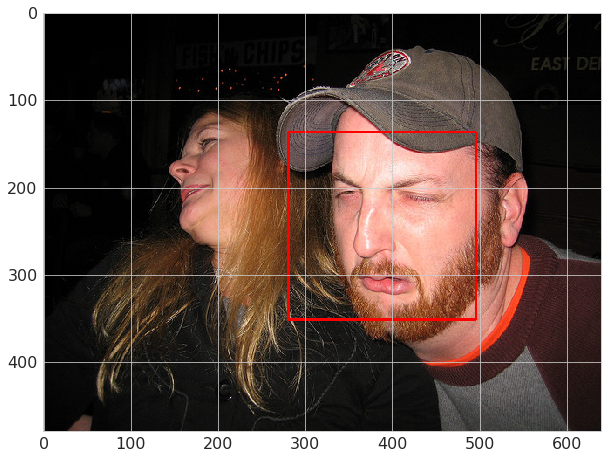

In [12]:
plt.imshow(image_detector[:,:,::-1])

In [13]:
cv2.imwrite('figs/detected.jpg', image_detector)

True

## Cropping around the face

In [14]:
from cpe775.utils import io_utils, img_utils

In [15]:
df = io_utils.read_pts(['../data/300W/02_Outdoor/outdoor_255.pts'])
landmarks = df.loc[0, 1:].values.reshape((68,2))

In [16]:
bbox = img_utils.get_bbox_from_landmarks(landmarks)
rect = img_utils.enlarge_bbox(bbox, ratio=1.7)

In [17]:
left, top, width, height = rect

In [18]:
image_detector = image.copy()
img_large_rect = cv2.rectangle(image_detector, (left, top), (left + width, top + height), (0, 0, 255), 2)

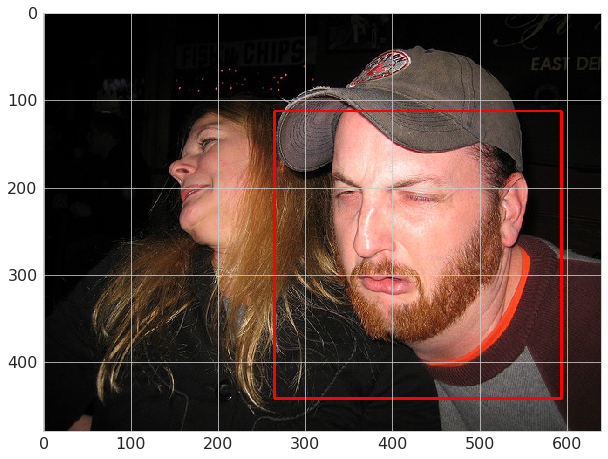

In [19]:
plt.imshow(img_large_rect[:,:,::-1])

In [20]:
cv2.imwrite('figs/large.jpg', img_large_rect)

True

## Cropping image around the face

In [21]:
cropped_img = image[top:(top+height), left:(left+width), :].copy()
cropped_landmarks = landmarks
cropped_landmarks[:, 0] -= left
cropped_landmarks[:, 1] -= top

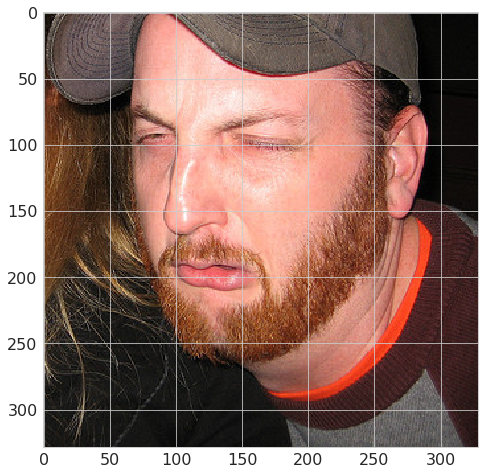

In [22]:
plt.imshow(cropped_img[:,:,::-1])

In [23]:
cv2.imwrite('figs/cropped.jpg', cropped_img)

True

## Downsampling

In [24]:
h, w = cropped_img.shape[:-1]
downsampled_img = cv2.resize(cropped_img, (256, 256), interpolation = cv2.INTER_CUBIC)
normalized_landmarks = cropped_landmarks
normalized_landmarks[:, 0] *= 256/w
normalized_landmarks[:, 1] *= 256/h

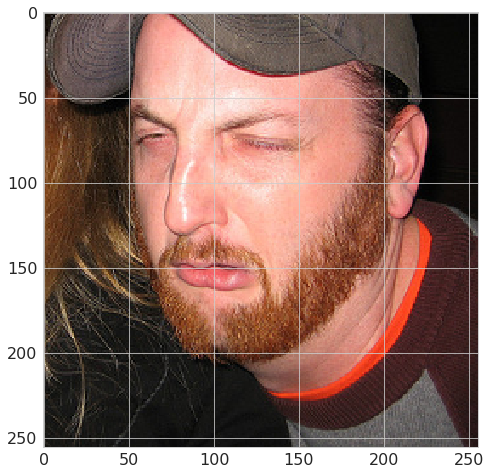

In [25]:
plt.imshow(downsampled_img[:,:,::-1])

In [26]:
cv2.imwrite('figs/downsampled.jpg', downsampled_img)

True

## Center crop

In [27]:
w, h = downsampled_img.shape[:-1]
th, tw = 224, 224
i = int(round((h - th) / 2.))
j = int(round((w - tw) / 2.))

normalized_landmarks -= [j, i]

centered_img = downsampled_img[i:(i+h), j:(j+w), :]

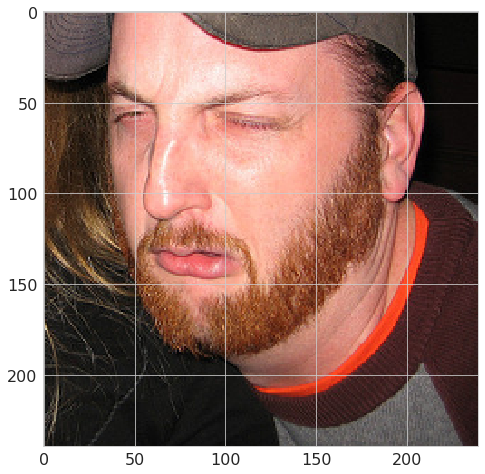

In [28]:
plt.imshow(centered_img[:,:,::-1])

In [29]:
cv2.imwrite('figs/centered.jpg', centered_img)

True

## Finding the landmarks

In [32]:
img_land = centered_img.copy()
for (x, y) in normalized_landmarks:
     cv2.circle(img_land, (int(x), int(y)), 1, (0, 0, 255), -1)

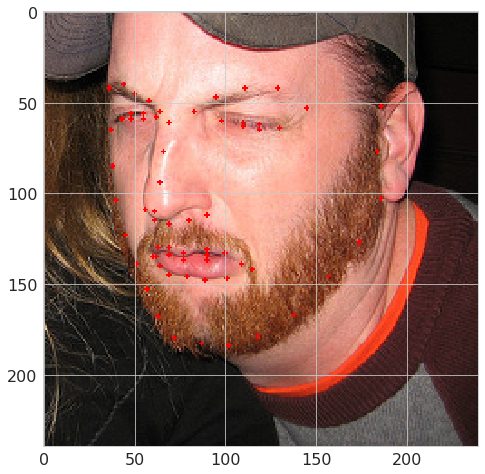

In [33]:
plt.imshow(img_land[:,:,::-1])

In [43]:
cv2.imwrite('figs/landmarks.jpg', img_land)

True

In [38]:
df = io_utils.read_pts(['../data/300W/02_Outdoor/outdoor_255.pts'])
landmarks = df.loc[0, 1:].values.reshape((68,2))
land_img = image.copy()
for (x, y) in landmarks:
     cv2.circle(land_img, (int(x), int(y)), 1, (0, 0, 255), -1)

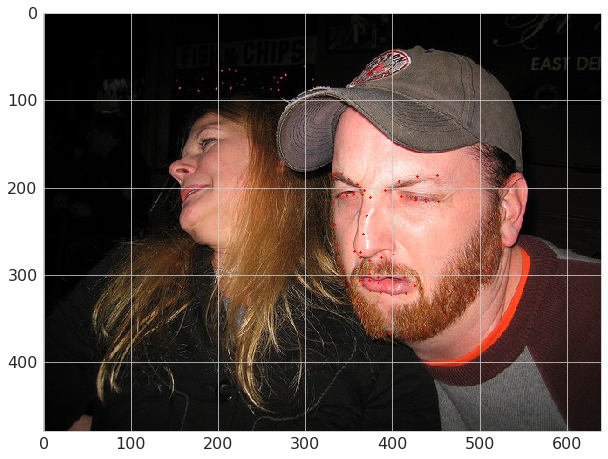

In [39]:
plt.imshow(land_img[:,:,::-1])

In [42]:
cv2.imwrite('figs/orig_landmarks.jpg', land_img)

True

## Aligning

In [60]:
from cpe775.align import AlignDlib, MINMAX_TEMPLATE

In [45]:
align = AlignDlib()

In [56]:
centered = align(centered_img/255, normalized_landmarks)

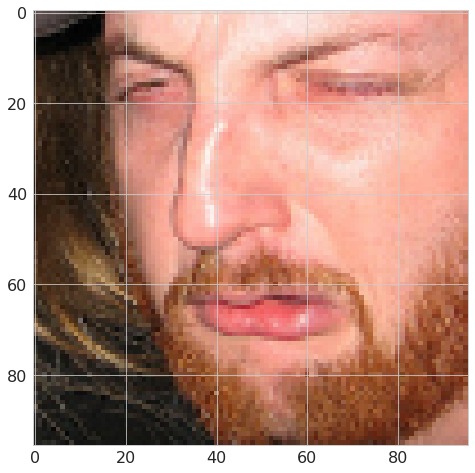

In [57]:
plt.imshow(centered[:, :, ::-1])

In [70]:
cv2.imwrite('figs/centered_cropped.jpg', (centered*255).astype(np.uint8))

True

In [67]:
template = centered.copy()
for (x, y) in MINMAX_TEMPLATE:
     cv2.circle(template, (int(x*96), int(y*96)), 1, (0, 0, 255), -1)

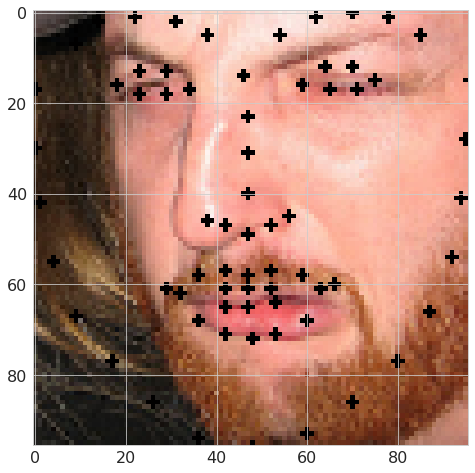

In [68]:
plt.imshow(template[:, :, ::-1])